In [1]:
import warnings

warnings.filterwarnings('ignore')

# 锂电池材料计算简介

*Copyright (c) 2022 Institute for Quantum Computing, Baidu Inc. All Rights Reserved.*

锂电池是一种高效、长寿命的电池，广泛用于各种消费类电子产品、工业设备和汽车动力系统中。锂电池的发展促进了电动汽车的普及，也为可再生能源储存提供了重要支撑。由于锂电池具有轻量、高能量密度和环保等优点，其应用前景广阔，且行业发展前景好。目前，锂电池行业正在经历快速发展，并不断创新和推广新技术。

在锂电池中，能量主要通过电池正负极物质之间的电化学反应产生，
$$
LiC_6+CoO_2\stackrel{放电}{\underset{\text{充电}}{\rightleftarrows}}6C+LiCoO_2.
$$

根据热力学规律，这个能量等于放电反应前后正负极物质自由能\[1\]的变化量，在多数情况下，它可以通过反应前后物质的基态能量差进行估计\[2\]
$$
\Delta G=G_{\text{LiCoO}_2}+6G_{\text{C}}-G_{\text{CoO}_2}-G_{\text{LiC}_6}.
$$

综上，由于化学反应的能量与反应方程式两侧分子/物质的能量有紧密联系，我们在衡量锂电池释放的总能量时就需要对相关分子/物质的基态能量有比较精确的估计。同时，反应中锂离子通过电解液在正负极之间迁移的过程也会涉及到离子在分子和材料表面的吸附，这会受到分子电极化情况的影响。

## 利用量子计算化学方法计算分子基态性质
### 构建分子哈密顿量
分子哈密顿量由分子的几何结构和组成的原子决定，利用 `paddle_quantum` 的 `qchem` 模块，用户可以很方便地完成从分子的结构到哈密顿量的计算过程。

In [3]:
from paddle_quantum.qchem import Molecule, PySCFDriver

mol = Molecule(
    geometry = [("H", [0.0, 0.0, 0.0]), ("H", [0.0, 0.0, 0.7])],
    driver = PySCFDriver()
)

由此，我们就新建了一个氢分子模型。在上面的代码中，`driver` 是用来计算哈密顿量中分子积分所使用的经典量子化学计算工具。

In [4]:
h = mol.get_molecular_hamiltonian()
print(h)

converged SCF energy = -1.11734903499028
-0.04207897647782183 I
0.17771287465139923 Z0
0.17771287465139923 Z1
-0.24274280513140506 Z2
-0.24274280513140506 Z3
0.17059738328801052 Z0, Z1
0.12293305056183806 Z0, Z2
0.16768319457718972 Z0, Z3
0.16768319457718972 Z1, Z2
0.12293305056183806 Z1, Z3
0.1762764080431961 Z2, Z3
-0.044750144015351656 X0, X1, Y2, Y3
0.044750144015351656 X0, Y1, Y2, X3
0.044750144015351656 Y0, X1, X2, Y3
-0.044750144015351656 Y0, Y1, X2, X3


这样就构造了一个氢分子在 `STO-3G` 基组下的哈密顿量。

### 搭建用于变分量子算法（VQE）的量子线路
变分量子算法通过使用经典优化器对量子算法中的可调参数进行优化的方式完成经典-量子混合计算，相比于经典算法，它可以在某些情况下更快地求解具有高维特征的优化问题。接下来，我们按照\[2\]中给出的方法构建如下图所示的量子线路。

converged SCF energy = -1.11734903499028


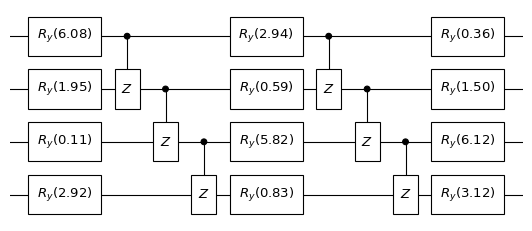

In [5]:
from paddle_quantum.qchem import HardwareEfficient

mol.build()
cir = HardwareEfficient(mol.num_qubits, depth=2)
cir.plot()

### 计算氢分子势能面
下面我们通过计算氢分子势能面的任务来展示一下 VQE 方法的使用。分子势能面刻画了分子的能量随着分子内部原子的空间位置变化的规律，它在物理和化学中有很广泛的应用，经常被用于寻找分子的最优几何结构以及计算化学反应速率。对于氢分子来说，因为内部只有一个空间自由度（两个氢原子之间的距离），它的势能面实际上是一条曲线。

In [9]:
import numpy as np
import paddle
from paddle.optimizer import Adam
from paddle_quantum.qchem import GroundStateSolver
from paddle_quantum.qchem import dipole_moment

paddle.seed(124)

cir_depth = 2
bond_lengthes = [0.1, 0.3, 0.5, 0.74, 0.9, 1.0, 1.5, 2.0]
energies = []
dipole_moments = []
for bond_len in bond_lengthes:
    mol = Molecule(
        geometry = [("H", [0.0, 0.0, 0.0]), ("H", [0.0, 0.0, bond_len])],
        driver = PySCFDriver()
    )
    mol.build()
    
    cir = HardwareEfficient(mol.num_qubits, cir_depth)

    solver = GroundStateSolver(Adam, num_iterations=100, tol=1e-5)
    e, psi = solver.solve(cir, mol=mol, learning_rate=0.5)
    energies.append(e)

    # calculate dipole moments
    d = dipole_moment(psi, mol)
    dipole_moments.append(np.linalg.norm(d))

converged SCF energy = 2.71588739329275
converged SCF energy = -0.593827758535727
converged SCF energy = -1.04299627454009
converged SCF energy = -1.11675930739643
converged SCF energy = -1.09191404102006
converged SCF energy = -1.06610864931794
converged SCF energy = -0.910873554594387
converged SCF energy = -0.783792654277353


我们画出计算结果，可以看出氢分子的基态能量随着两个氢原子之间的距离增大先下降后上升，能量最低点对应的键长（也即平衡位置）为 0.74 埃。氢分子是一个非极性的分子，不管键长如何变化，它的偶极矩始终为零。

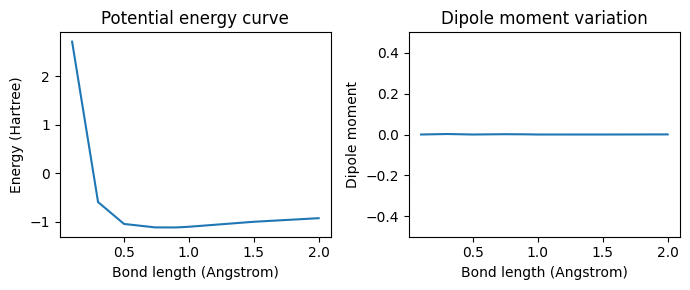

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7, 3), )
ax1 = fig.add_subplot(121)
ax1.plot(bond_lengthes, energies)
ax1.set_xlabel("Bond length (Angstrom)")
ax1.set_ylabel("Energy (Hartree)")
ax1.set_title("Potential energy curve")

ax2 = fig.add_subplot(122)
ax2.plot(bond_lengthes, dipole_moments)
ax2.set_xlabel("Bond length (Angstrom)")
ax2.set_ylabel("Dipole moment")
ax2.set_title("Dipole moment variation")
ax2.set_ylim(-0.5, 0.5)
fig.tight_layout()

## 如何使用
用户可以通过编辑配置文件`config.toml`对计算任务进行自定义，其中用户需要设置的参数如下：
```toml
# A description of the task of this configuration file, this is optional. "GroundState" stands for calculate the ground state energy of the molecule.

# This field stores information related to the molecule is provided.
[molecule]
# Symbols of atoms inside the molecule.
symbols = ['H', 'H']
# The cartesian coordinates of each atom inside the molecule.
coords = [ [ 0.0, 0.0, 0.0 ], [ 0.0, 0.0, 0.7 ] ]

# This field specifies configurations related to the quantum circuit in VQE is specified.
[ansatz.HardwareEfficient]
# The depth of the HardwareEfficient ansatz.
depth = 2

# This field stores configurations of the variational quantum eigensolver (VQE) method. 
[VQE]
# Number of optimization cycles, default is 100.
num_iterations = 100
```
用户可以通过在命令行中运行
```shell
python energy_material.py --config example.toml
```
的方式来完成量子化学计算任务。

## 参考文献
\[1\] [百度百科-自由能](https://baike.baidu.com/item/%E8%87%AA%E7%94%B1%E8%83%BD/813477?fr=aladdin)

\[2\] Aydinol, M. K., et al. "Ab initio study of lithium intercalation in metal oxides and metal dichalcogenides." Physical Review B 56.3 (1997): 1354.

\[3\] Kandala, Abhinav, et al. "Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets." Nature 549.7671 (2017): 242-246.